# Objective: 

Instead of treating text, audio, and video as separate streams of information, you will design a **Transformer-based model that intelligently fuses two modalities**—text with images, text with audio, or text with video. Your challenge is to harness the power of deep learning to create a system where each modality enhances the other, unlocking richer, more meaningful insights.

This is more than just training a model—it’s about innovation. How will you design a fusion strategy that truly captures cross-modal relationships? Will your model generate creative text from images, answer questions from audio, or retrieve videos based on descriptions? The decisions are yours to make.

Even if you and your peers work with similar datasets, your approach must be unique. Whether through data choices, architectural modifications, or fusion techniques, your model should push the boundaries of multimodal AI. Experiment boldly, optimize strategically, and most importantly—create something exciting.



In [1]:
import os
import pandas as pd
from datasets import Dataset, Audio, ClassLabel, DatasetDict
import numpy as np

audio_path = "/kaggle/input/google-speech-commands/"  # Verify this path in your Kaggle env

# Create dataset from directory structure
def create_dataset_dict(root_dir, target_labels):
    data = {"file": [], "label": []}
    
    # Traverse directory tree
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir) and label in target_labels:
            for fname in os.listdir(label_dir):
                if fname.endswith(".wav"):
                    data["file"].append(os.path.join(label_dir, fname))
                    data["label"].append(label)
    
    # Convert to HuggingFace Dataset
    full_ds = Dataset.from_dict(data).cast_column("file", Audio())
    
    # Create train/validation/test splits (70/15/15)
    split = full_ds.train_test_split(test_size=0.3, seed=42)
    test_valid = split["test"].train_test_split(test_size=0.5, seed=42)
    
    return DatasetDict({
        "train": split["train"],
        "validation": test_valid["train"],
        "test": test_valid["test"]
    })

# Initialize dataset with our target labels
target_labels = ['up', 'down', 'left', 'right', 'zero', 'one', 'two', 
                'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
                'on', 'off', 'go', 'yes', 'no']

dataset = create_dataset_dict(audio_path, target_labels)

# Verify dataset structure
print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"Sample entry: {dataset['train'][0]}")

Train samples: 31477
Validation samples: 6745
Test samples: 6746
Sample entry: {'file': {'path': '/kaggle/input/google-speech-commands/yes/333784b7_nohash_2.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -6.10351562e-05, -6.10351562e-05,  0.00000000e+00]), 'sampling_rate': 16000}, 'label': 'yes'}


In [2]:
# Create label mappings
label2id = {label: i for i, label in enumerate(target_labels)}
id2label = {i: label for i, label in enumerate(target_labels)}

id2label

{0: 'up',
 1: 'down',
 2: 'left',
 3: 'right',
 4: 'zero',
 5: 'one',
 6: 'two',
 7: 'three',
 8: 'four',
 9: 'five',
 10: 'six',
 11: 'seven',
 12: 'eight',
 13: 'nine',
 14: 'on',
 15: 'off',
 16: 'go',
 17: 'yes',
 18: 'no'}

100%|██████████| 31477/31477 [00:00<00:00, 2304407.37it/s]


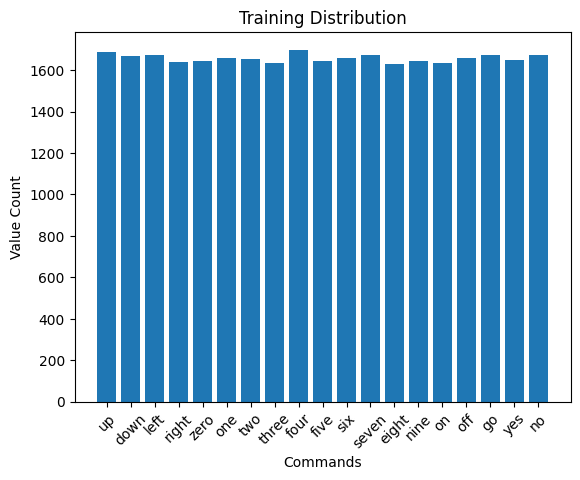

<Figure size 1600x400 with 0 Axes>

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

training_count = {label : 0 for label in target_labels}

label_dataset = dataset['train']['label']
for label in tqdm(label_dataset):
    training_count[label] += 1

names, values = list(training_count.keys()), list(training_count.values())

plt.bar(names, values)
plt.xlabel("Commands")
plt.xticks(names, rotation=45)
plt.ylabel("Value Count")
plt.title("Training Distribution")
plt.figure(figsize=(16,4))
plt.show()

In [4]:
# Audio preprocessing
from transformers import AutoFeatureExtractor

# Feature extractor will be used to process audio data
model_id = "superb/wav2vec2-base-superb-ks"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [5]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["file"]]
    
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        max_length=16000,  # 1-second clips
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    labels = [label2id[label] for label in examples["label"]]
    
    return {
        "input_values": inputs.input_values,
        "numerical_label": labels 
    }

# Apply preprocessing
encoded_dataset = dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,
    remove_columns=["file"]  # Keep label for verification
)

# Convert labels to ClassLabel
encoded_dataset = encoded_dataset.cast_column("numerical_label", ClassLabel(names=list(label2id.keys())))

Map:   0%|          | 0/31477 [00:00<?, ? examples/s]

Map:   0%|          | 0/6745 [00:00<?, ? examples/s]

Map:   0%|          | 0/6746 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/31477 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6745 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6746 [00:00<?, ? examples/s]

In [6]:
from transformers import Wav2Vec2ForSequenceClassification
import torch.nn as nn

# Model Architecture
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(target_labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-ks and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([12, 256]) in the checkpoint and torch.Size([19, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([12]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Set dataset format for PyTorch compatibility
encoded_dataset.set_format("torch", columns=["label", "input_values", "numerical_label"])

  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-21-5f729685a056>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch["input_values"]).to(device)
<ipython-input-21-5f729685a056>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["numerical_label"]).to(device)


Epoch 1:


 17%|█▋        | 1/6 [09:43<48:36, 583.27s/it]

Epoch 2:


 33%|███▎      | 2/6 [19:55<40:01, 600.40s/it]

Epoch [2/6] | Train Loss: 0.2244 | Val Loss: 0.0987 | Val Acc: 0.9749
Epoch 3:


 50%|█████     | 3/6 [29:38<29:37, 592.48s/it]

Epoch 4:


 67%|██████▋   | 4/6 [39:51<20:00, 600.37s/it]

Epoch [4/6] | Train Loss: 0.1951 | Val Loss: 0.0873 | Val Acc: 0.9769
Epoch 5:


 83%|████████▎ | 5/6 [49:35<09:54, 594.41s/it]

Epoch 6:


100%|██████████| 6/6 [59:47<00:00, 597.91s/it]

Epoch [6/6] | Train Loss: 0.1779 | Val Loss: 0.0862 | Val Acc: 0.9785


ValueError: x and y must have same first dimension, but have shapes (6,) and (3,)

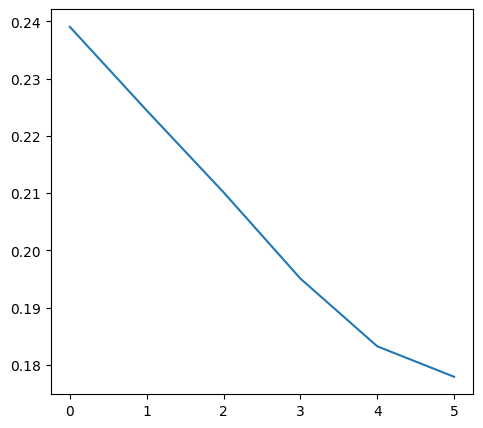

In [21]:
import torch

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 6
LEARNING_RATE = 1e-5

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Metrics tracking
train_losses = []
val_losses = []
val_accuracies = []

epoch_count = 0
for epoch in tqdm(range(EPOCHS)):
    epoch_count += 1
    print(f"Epoch {epoch_count}:")
    
    # Training Phase
    model.train()
    epoch_train_loss = 0
    
    for batch in encoded_dataset["train"].shuffle().iter(batch_size=BATCH_SIZE):
        inputs = torch.tensor(batch["input_values"]).to(device)
        labels = torch.tensor(batch["numerical_label"]).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)        
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(encoded_dataset["train"]) * BATCH_SIZE
    train_losses.append(avg_train_loss)
    
    # Validation every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in encoded_dataset["validation"].iter(batch_size=BATCH_SIZE):
                inputs = batch["input_values"].to(device)
                labels = batch["numerical_label"].to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(encoded_dataset["validation"]) * BATCH_SIZE
        val_accuracy = correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

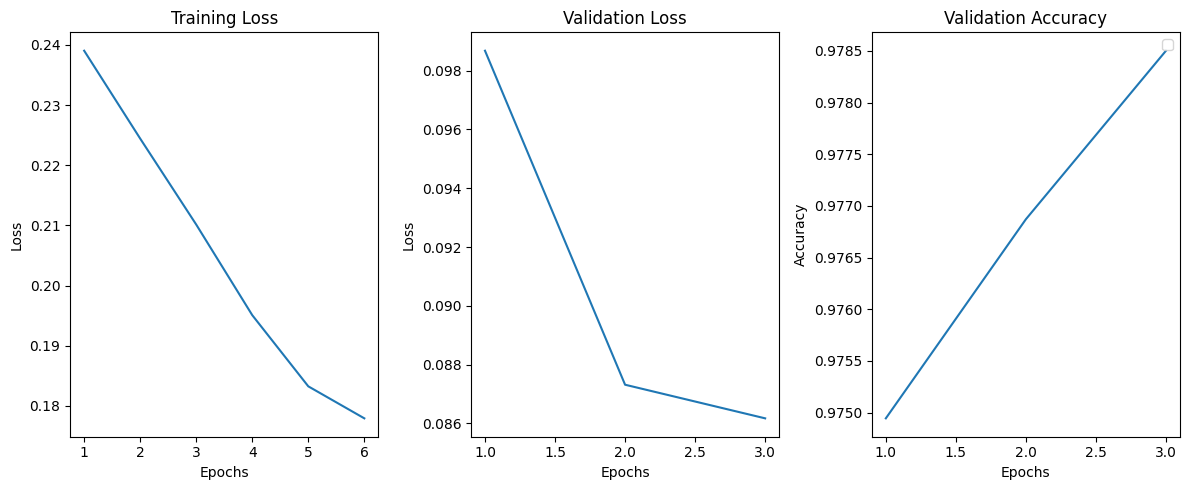

In [41]:
# Plot training curves
plt.figure(figsize=(12, 5))

train_count = EPOCHS + 1
val_count = int(EPOCHS / 2 + 1)

# Train Loss plot
plt.subplot(1, 3, 1)
plt.plot(range(1,train_count), train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")

# Train Loss plot
plt.subplot(1, 3, 2)
plt.plot(range(1,val_count), val_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1,val_count), val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

In [53]:
# Test evaluation
model.eval()
test_correct = 0
test_total = 0
wrong_dist = {label: 0 for label in target_labels}

for batch in tqdm(encoded_dataset["test"].iter(batch_size=BATCH_SIZE)):
    inputs = batch["input_values"].to(device)
    labels = batch["numerical_label"].to(device)
    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.logits, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

    if labels.size(0) != (predicted == labels).sum().item():
        incorrect_mask = (predicted != labels)
        incorrect_labels = labels[incorrect_mask]
        
        for label_idx in incorrect_labels.cpu().numpy():
            label_name = id2label[label_idx]
            wrong_dist[label_name] += 1
            
print(f"Test Accuracy: {test_correct/test_total:.4f}")

211it [00:29,  7.21it/s]

Test Accuracy: 0.9760


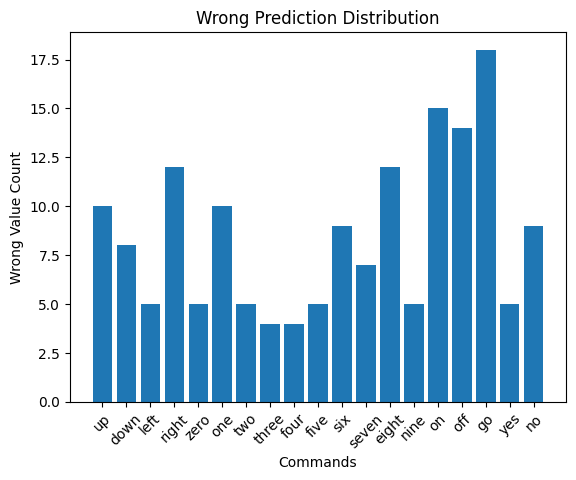

<Figure size 1600x400 with 0 Axes>

In [55]:
# Wrong Answer Distribution
names, values = list(wrong_dist.keys()), list(wrong_dist.values())

plt.bar(names, values)
plt.xlabel("Commands")
plt.xticks(names, rotation=45)
plt.ylabel("Wrong Value Count")
plt.title("Wrong Prediction Distribution")
plt.figure(figsize=(16,4))
plt.show()

In [56]:
# Saving Model Weights
saved_path = "/kaggle/working/wav2vec2_model_weights.pth"
torch.save(model.state_dict(), saved_path)

In [60]:
# Example of Loading in Model Weights
loaded_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(target_labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

loaded_model.load_state_dict(torch.load(saved_path))

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-ks and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([12, 256]) in the checkpoint and torch.Size([19, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([12]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-60-fc9933a5ae4b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor

<All keys matched successfully>